In [21]:
#import all the required libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


In [5]:
#Downloaded and loaded smoothed us-101 highway dataset.
#dataset can be found here : https://github.com/Rim-El-Ballouli/NGSIM-US-101-trajectory-dataset-smoothing/tree/master/smoothed-dataset/window-11 
df = pd.read_csv("dataset/0750_0805_us101_smoothed_11_.csv")

In [6]:
#printing head of the dataset.
df.head()

,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_Length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Preceeding,Following,Space_Hdwy,Time_Hdwy
0,2,13,437,1118846980200,16.467196,35.380427,6451137.641,1873344.962,14.5,4.9,2,40.000000,0.000000,2,0,0,0.0,0.0
1,2,14,437,1118846980300,16.446594,39.381608,6451140.329,1873342.000,14.5,4.9,2,40.012349,0.123485,2,0,0,0.0,0.0
2,2,15,437,1118846980400,16.425991,43.381541,6451143.018,1873339.038,14.5,4.9,2,39.999855,-0.124939,2,0,0,0.0,0.0
3,2,16,437,1118846980500,16.405392,47.380780,6451145.706,1873336.077,14.5,4.9,2,39.992920,-0.069349,2,0,0,0.0,0.0
4,2,17,437,1118846980600,16.384804,51.379881,6451148.395,1873333.115,14.5,4.9,2,39.991544,-0.013759,2,0,0,0.0,0.0


In [8]:
#selecting only required columns form the above loaded dataset.
df_new = df[["Vehicle_ID","Global_Time","Local_X","Local_Y","v_Vel","v_Acc","Space_Hdwy", "Time_Hdwy"]]

#df_new.to_csv("new_csv.csv")

In [9]:
#getting unique list of vehicle ids.
v_ids = df_new["Vehicle_ID"].unique().tolist()
print(len(v_ids))

1993


In [52]:
# this section will get values of each unique vehicle id and store the mean of each column in the lists.
avg_vel = []
avg_acc = []
avg_shdwy = []
avg_thdwy = []

y_local_list = []
for i in v_ids:
    vid_df = df_new[df_new["Vehicle_ID"] == i]
    avg_df = vid_df[["v_Vel","v_Acc","Space_Hdwy", "Time_Hdwy"]].mean(axis = 0) 
    avg_vel.append(avg_df.v_Vel)
    avg_acc.append(avg_df.v_Acc)
    avg_shdwy.append(avg_df.Space_Hdwy)
    avg_thdwy.append(avg_df.Time_Hdwy)
    
print(len(avg_vel))
print(len(avg_acc))
print(len(avg_shdwy))
print(len(avg_thdwy))
    

1993
1993
1993
1993


In [53]:
#creating dataframe from the obtained lists of mean values of the selected features
id_df = pd.DataFrame(list(zip(v_ids,avg_vel,avg_acc,avg_shdwy,avg_thdwy)),
               columns =['Vehicle Id', 'Avg Velocity', 'Avg Acceleration', 'Avg Space_head','Avg Time_head'])
id_df.head()

,Vehicle Id,Avg Velocity,Avg Acceleration,Avg Space_head,Avg Time_head
0,2,48.041722,0.686125,0.000000,0.000000
1,4,46.345358,0.409664,0.000000,0.000000
2,5,46.245079,0.541758,0.000000,0.000000
3,6,46.591721,0.204813,50.560700,1.082269
4,8,46.751656,0.341532,70.087545,1.519107


In [54]:
# calling kmeans clustering algorithm
kmeans = KMeans(n_clusters=3) # 3 clusters to train 3 classes Aggressive, Moderate and Normal


#training on selected features
y = kmeans.fit_predict(id_df[['Avg Velocity', 'Avg Acceleration', 'Avg Space_head', 'Avg Time_head']]) 

#assigining trained cluster class
id_df['Cluster'] = y

print(id_df.head())

   Vehicle Id  Avg Velocity  Avg Acceleration  Avg Space_head  Avg Time_head  \
0           2     48.041722          0.686125        0.000000       0.000000   
1           4     46.345358          0.409664        0.000000       0.000000   
2           5     46.245079          0.541758        0.000000       0.000000   
3           6     46.591721          0.204813       50.560700       1.082269   
4           8     46.751656          0.341532       70.087545       1.519107   

   Cluster  
0        0  
1        0  
2        0  
3        0  
4        0  


In [55]:
#section to get mean of all the classified features to understance the classification
means_list = []
for id in [0,1,2]:
    new_id = id_df[id_df["Cluster"] == id]
    means = new_id.mean(axis = 0)
    # print(means)
    # print(len(new_id))
    means_list.append([len(new_id), new_id["Avg Velocity"].mean(),
                       new_id["Avg Acceleration"].mean(),
                       new_id["Avg Space_head"].mean(),
                       new_id["Avg Time_head"].mean()])

means_df = pd.DataFrame(means_list,index = ["Aggrasive", "Moderate", "Normal"], columns= ['Id Count','Avg Vel','Avg_Acc','Avg_SpaceH','Ave_TimeH'])
print(means_df.head())

           Id Count    Avg Vel   Avg_Acc  Avg_SpaceH    Ave_TimeH
Aggrasive      1818  41.880956  0.427515   81.162913     8.065465
Moderate        106  28.258050  0.123958   67.078214   534.086185
Normal           69  27.038102  0.177454   64.364374  1132.907198


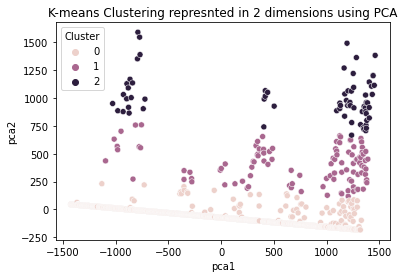

In [59]:

#pca training to reduce 4d to 2d ro present data in a 2d graph
pca_num_components = 2

reduced_data = PCA(n_components=pca_num_components).fit_transform(id_df)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])

#plotting the 2d featured plot of driving style classes
sns.scatterplot(x="pca1", y="pca2", hue=id_df['Cluster'], data=results)
plt.title('K-means Clustering represnted in 2 dimensions using PCA')
#plt.legend(["Aggressive", "Moderate", "Normal"])
plt.show()